<a href="https://colab.research.google.com/github/raulbs7/Machine-Learning-Techniques-Project/blob/master/NLP_Supervised_Project/4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. TWEETS CLASSIFICATION

## 4.1 Imports

In [26]:
import pandas as pd
import numpy as np
import io
import scipy.sparse as sp

from google.colab import files
from google.colab import drive


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

## 4.2 Importing files

It is needed to import two files:


*   **processed_tweets.csv**: this CSV contains the original preprocessed tweets with the corresponding labels of each tweet.
*   **selected_features.npz**: this is a file with an **.npz** extension, which returns an sparse matrix, that can be used by many machine learning algorithms like dataframes.



In [2]:
def upload_dataframes (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

In [3]:
def upload_matrix ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    matrix = sp.load_npz(fn)
    return matrix

In [4]:
tweets = upload_dataframes([])

Saving processed_tweets.csv to processed_tweets.csv
User uploaded file "processed_tweets.csv" with length 1558482 bytes


In [5]:
features = upload_matrix()

Saving selected_features.npz to selected_features.npz
User uploaded file "selected_features.npz" with length 2757255 bytes


This is the form each data:

In [6]:
tweets

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt woman complain cleaning house man always ta...
1,1,3,0,3,0,1,rt boy dat coldtyga dwn bad cuffin dat hoe 1st...
2,2,3,0,3,0,1,rt dawg rt ever fuck bitch start cry confused ...
3,3,3,0,2,1,1,rt look like tranny
4,4,6,0,6,0,1,rt shit hear might true might faker bitch told...
...,...,...,...,...,...,...,...
24778,24778,3,0,2,1,1,yous muthafin lie right tl trash … mine bible ...
24779,24779,3,0,1,2,2,gone broke wrong heart baby drove redneck crazy
24780,24780,3,0,3,0,1,young buck wan na eat dat nigguh like aint fuc...
24781,24781,6,0,6,0,1,youu got wild bitch tellin lie


In [7]:
features

<24783x2548 sparse matrix of type '<class 'numpy.float64'>'
	with 381643 stored elements in Compressed Sparse Row format>

### 4.3 Preprocessing

It is recommendable, before creating the classification model of the tweets dataset, to move to the same scale the selected features extracted by the vectorization of these tweets. This is done by the normalization.

In [8]:
features_norm = sp.csr_matrix(MinMaxScaler().fit_transform(features.todense()))

Also it would be helpful to see how many entries correspond to each of the classes.

class
0     1430
1    19190
2     4163
dtype: int64


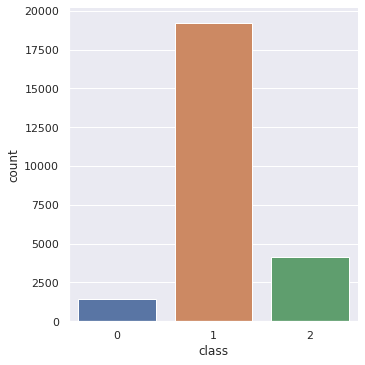

In [9]:
print(tweets.groupby('class').size())
sns.set(style='darkgrid') 
sns.catplot(x='class', data=tweets, kind='count')

## 4.4 Naive Bayes Classification

The first classification algorithm applied to the tweets is going to be the naive bayes classification. This algorithm is caracterized of being the preferred for text classification, due to be better with multi class problems.



### 4.4.1 Splitting train and test

After having features normalized, the next step necessary to do supervised learning is to split the dataset into train and test sets. In this case, the features that are going to be analyzed and the labels that are going to be predicted, they are separated, so the the different sets also will be separated. The labels of our dataset is represented by the **class** column of the tweets dataframe **processed_tweets.csv**.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_norm, tweets['class'], test_size=.3)

### 4.4.2 Cross validation

The Naive Bayes algorithm have different implementations. For this reason it is necessary to choose the one that have a better performance in its predictions and the one that has the better accuracy score.

---
The method above have one disadvantage. This disadvantage is that the model can become complex and not very general for other data. To avoid that, one solution is to do cross validation. This consists into split the train set into other subsets of train and test, and do this many times to have more realistic evaluation of the model.

In [11]:
# Preparing the cross validation
cv = KFold(n_splits=10, shuffle=True)

In [12]:
# Listing alf the different implementations of Naive Bayes
names = ['GaussianNB', 'MultiNomialNB', 'BernoulliNB', 'ComplementNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]

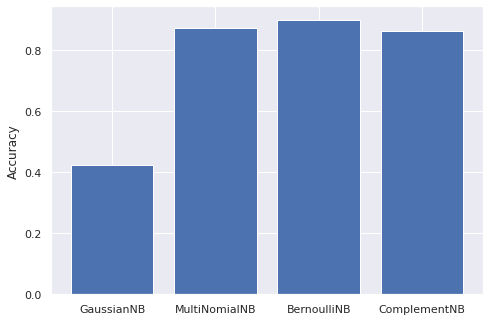

In [13]:
classifiers_acc = []

for clf in classifiers:
  fold_accuracy = []
  for train_fold, test_fold in cv.split(X_train, y_train):
    # Random division of the train set to do cross validation
    f_train_X = X_train[train_fold]
    f_test_X = X_train[test_fold]
    f_train_y = y_train.iloc[train_fold]
    f_test_y = y_train.iloc[test_fold]
    # FIT THE MODEL
    f_model = clf.fit(f_train_X.todense(), f_train_y)
    # PREDICT AND SCORE
    accuracy = f_model.score(f_test_X.todense(), f_test_y)
    fold_accuracy.append(accuracy)
  classifiers_acc.append(sum(fold_accuracy)/len(fold_accuracy))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(names, classifiers_acc)
plt.ylabel('Accuracy')
plt.show()

The model that have better accuracy is the BernoulliNB, so it will be the implementation used. This result could be explained because it assumes that features are binary-valued variable, and the vectorization of the tweets have a very similar behaviour.

### 4.4.3 Building model

The implementation of Naive Bayes algorithm choosen is BernoulliNB, for the creation of the model.

In [14]:
clf = BernoulliNB() 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print ('Accuracy of the Naive Bayes model: ', acc)
print ('Precision of the Naive Bayes model: ', precision)
print ('Recall of the Naive Bayes model: ', recall)
print ('F-measure of the Naive Bayes model: ', f1)

Accuracy of the Naive Bayes model:  0.8925353059852051
Precision of the Naive Bayes model:  0.8913485343329399
Recall of the Naive Bayes model:  0.8925353059852051
F-measure of the Naive Bayes model:  0.8918336070712607


### 4.4.4 Evaluation of the model

For the evaluation, it will be shown the confusion matrix, that represents the real labels comparated with the labels predicted, and if the predictions were correct or not.

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

As a reminder, the classes represents the following:



*   0. Hate speech tweets.
*   1. Offensive language tweets
*   2. Neither tweets



Normalized confusion matrix
[[0.43809524 0.44761905 0.11428571]
 [0.03314246 0.93406212 0.03279542]
 [0.00958466 0.13658147 0.85383387]]


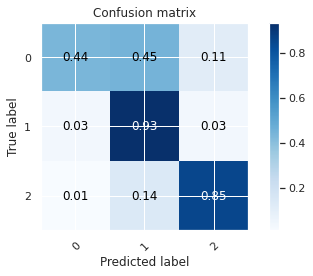

In [16]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred),
                      normalize=True, title='Confusion matrix')

The confusion matrix shows that there is a great percentage of true predicted offensive language tweets and _neither_ tweets. The conflict is the fact that there are some tweets that there is a great percentage of tweets predicted as offensive language, being really hate speech tweets. This may be because both labels are very correlated and similar, because they are difficult to differentiate each other, even for one human.

Text(89.18, 0.5, 'predicted label')

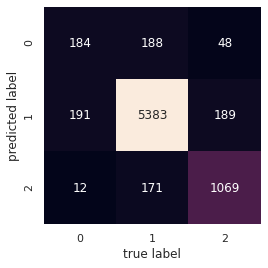

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label')

The class with more affluence of tweets is the offensive language tweets. The class with less affluence of tweets is the hate speech tweets.

For this reason, the error in this class is not as relevant as the other classes. This is why the accuracy is not very affected by this false values.

## 4.5 K-Nearest-Neighbours

The next classification algorithm used will be the **Random Forests**. This is a machine learning algorithm that is made of ensembles, which is an aproach to the divide-and-conquer idea. This implementation improves the performance of the model. The result of this model is the combination of trees to create a robust model.  

### 4.5.1 Splitting train and test

As well as Naive Bayes classifier, it is also necessary to split the dataset in train and test sets. It is possible to use the above splitted data, but, for having a better model, the splitting is going to be done another time. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features_norm, tweets['class'], test_size=.3)

### 4.4.5 Cross validation

The goal is to train some models with cross validation to see how this model behaves with different bunch of train data, to avoid overfitting.

In [19]:
cv = KFold(n_splits=10, shuffle=True)

In [38]:
fold_accuracy = []

for train_fold, test_fold in cv.split(X_train, y_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train[train_fold]
  f_test_X = X_train[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = RandomForestClassifier().fit(f_train_X.todense(), f_train_y)
  # PREDICT AND SCORE
  accuracy = f_model.score(f_test_X.todense(), f_test_y)
  fold_accuracy.append(accuracy)
forest_accuracy = sum(fold_accuracy)/len(fold_accuracy)

print('Estimated accuracy of Random Forest implementation: ', forest_accuracy)

Estimated accuracy of Random Forest implementation:  0.8780840886956579


### 4.4.3 Building model

In [40]:
model = RandomForestClassifier() 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print ('Accuracy of the Naive Bayes model: ', acc)
print ('Precision of the Naive Bayes model: ', precision)
print ('Recall of the Naive Bayes model: ', recall)
print ('F-measure of the Naive Bayes model: ', f1)

Accuracy of the Naive Bayes model:  0.8831203765971756
Precision of the Naive Bayes model:  0.8671012716051739
Recall of the Naive Bayes model:  0.8831203765971756
F-measure of the Naive Bayes model:  0.8642526439101992


### 4.4.4 Evaluation of the model

As equal with NB, it will be shown the confusion matrix obtained by the testing of the model


*   0. Hate speech tweets.
*   1. Offensive language tweets
*   2. Neither tweets



Normalized confusion matrix
[[0.11486486 0.81756757 0.06756757]
 [0.00554017 0.96970222 0.02475762]
 [0.00411523 0.2436214  0.75226337]]


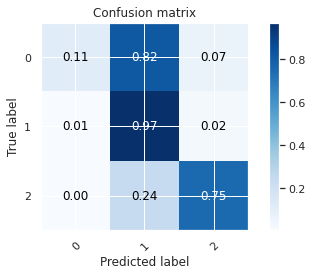

In [41]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred),
                      normalize=True, title='Confusion matrix')

Text(89.18, 0.5, 'predicted label')

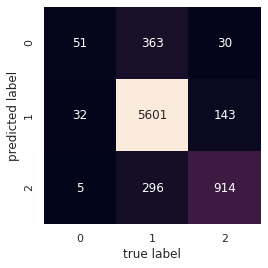

In [42]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 4.6 Conclusions

With all of these results, it is extracted that the model with better performance is the Naive Bayes model, against the Random Forests model. This difference can be explained, as mentioned before, because Naive Bayes is an algorithm used mostly for text classification. 

There are many reasons that can explain the popularity of Naive Bayes in this terms. 

One of these reasons could be the independence of each feature in the perform of the predictors. For example, if one word that is not polite, this can predict that it is an offensive tweet, indepently of the other words that appear in it.

Other reason can be the good performance with multilabeled classification.

Finally, it can be a good idea to implements techniques of implementing hyperparameter optimization for the algorithms to improve the models. However, it can mean a higher cost of training.